## Analyze A/B Test Results
Created: 10/07/2018<br>
Latest Update: 10/07/2018<br>
By: Can Bekleyici - bekleydata.com<br>


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed in data analysis and in data science. For this project, I worked to understand the results of an A/B test for an e-commerce website.  I created this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

To get started, the libraries have to be imported.

In [1]:
# Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Here, the `ab_data.csv` data has been stored in `df`.

a. Reading the dataset and viewing the first rows of the table

In [2]:
# Loading the CSV
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Finding the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# new_page and treatment don't line up in the cases of new_page&control + old_page&treatment:
df.query('landing_page == "new_page" & group == "control"').shape[0] + df.query('landing_page == "old_page" & group == "treatment"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Storing the new dataset in **df2**.

In [8]:
# Filtering the Dataframe so that it only includes the correct allignments:
df2 = df.query('landing_page == "new_page" & group == "treatment"')
df2 = df2.append(df.query('landing_page == "old_page" & group == "control"'))

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Explore the **df2** dataset

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. Are there repeated **user_id** in **df2**?

In [11]:
# Shows the index and user_id of the duplicated ID:
df2['user_id'][(df2['user_id'].duplicated() == True)]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
# Shows row at index 2893 (duplicate user)
df2.loc[2893]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Removing **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [13]:
df2.drop([2893], inplace=True)

`4.` Using **df2** to further explore probabilities observed in the dataset.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# Computation of the mean of conversions, which consists of 1s for True and 0s for False, as the proportion:
np.mean(df['converted'])

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
np.mean(df.query('group == "control"')['converted'])

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
np.mean(df.query('group == "treatment"')['converted'])

0.11891957956489856

d. What is the probability that an individual received the new page?

In [17]:
# Shows the probability of new_pages in the dataset
df.query('landing_page == "new_page"').shape[0] / df.shape[0]

0.5

e. Is there evidence that one page leads to more conversions?

In [18]:
# The Observation of differences in conversion, grouped by 'treatment' and 'control' groups:
obs_diff = np.mean(df.query('group == "treatment"')['converted']) - np.mean(df.query('group == "control"')['converted'])
obs_diff

-0.0014795997940775518

> Answer:<br>The preliminary observations suggest that the control group, which viewed the old page, was slightly more likely (about 0.15%) to convert than the treatment group. Further investigations need to be conducted in order to conclude the evidence.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, a decision will be made just based on all the data provided. We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. The null and alternative hypotheses are:

**$H_{0}$** :  **$p_{new}$** <= **$p_{old}$** <br> **$H_{1}$** :  **$p_{new}$** > **$p_{old}$**

`2.` We assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, an assumption that they are equal to the **converted** rate in **ab_data.csv** regardless of the page have been made. <br>

A sample size for each page equal to the ones in **ab_data.csv** have been chosen.<br>

The sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null has been performed below.  <br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
# The Conversion rate regardless of the web page
p_null = np.mean(df2['converted'])
p_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
# Same rate as in a.
p_null

0.11959708724499628

c. What is $n_{new}$?

In [21]:
# The number of new_page entries in the dataset
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
# The number of old_page entries in the dataset
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# Simulates one test for the average of n_new binomial flips with a convert rate of p_null:
new_page_converted = np.random.binomial(n=n_new, p=p_null) / n_new
new_page_converted

0.11769320762507741

f. Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# Simulates one test for the average of n_old binomial flips with a convert rate of p_null:
old_page_converted = np.random.binomial(n=n_old, p=p_null) / n_old
old_page_converted

0.11826617288709611

g. Finding $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# The difference in average conversions of new_page and old_page:
new_page_converted - old_page_converted

-0.0005729652620186931

h. Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Storing all 10,000 values in **p_diffs**.

In [26]:
# Simulates 10,000 tests for the average of n_old and n_new binomial flips with a convert rate of p_null and appends each result to p_diff:
p_diffs = []
pn = np.random.binomial(n=n_new, p=p_null, size=10000) / n_new
po = np.random.binomial(n=n_old, p=p_null, size=10000) / n_old
p_diffs.append(pn - po)

i. Plotting a histogram of the **p_diffs**.

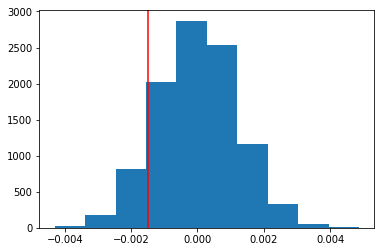

In [27]:
# Plots the null normal and the observation from our dataset:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# The proportion of null values which are greater than the observation from out dataset. Note that this proportion is equal to the p-value of our null hypothesis.
np.mean(p_diffs > obs_diff)

0.8877

k. What does this value mean in terms of whether or not there is a difference between the new and old pages?

> Answer:<br>The computed value of ~0.89 is called the p-value. This value indicates, in which extend the null hypothisis can be assumed to be true. With a treshhold of 5%, our p-value needs to be less than 0.05 in order to rightfully reject the null hypothisis and adapt the alternative. In this case, the p-value confirms our null hypothisis, stating the old page being at least equal or better than the new page with a confidentiality of about 89%.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.<br>

The number of conversions for each page, as well as the number of individuals who received each page were calculated. Let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [29]:
# Imports Statsmodels.api
import statsmodels.api as sm

# Computation of conversion rates and total entries for each web page:
convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Using `stats.proportions_ztest` to compute the test statistic and p-value.

In [30]:
# Computes the z-score and the p-value for our null hypothesis, defined as the alternative being p_new > p_old:
z_score, p_value = sm.stats.proportions_ztest((convert_new, convert_old), (n_new, n_old), alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> Answer:<br>The z-score indicates, how many standard deviations an element is from the mean. The p-score is the confidence level for our null hypothesis. The built-in function p-value is very close to the value that was computed through the bootstramp and is therefore confirmed.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. What type of regression should you be performing in this case?

> Answer: In this case, a logical regression is to be performed, because our response variable is categorical.

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, a column for the intercept, and create a dummy variable column for which page each user received needs to be created first. An **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**, has been added.

In [31]:
# Creates an intercept and dummy columns for the pages:
df2['intercept'] = 1
df2[['drop_this', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('drop_this', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Using **statsmodels** to import your regression model.  Instantiating the model, and fitting the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [32]:
# Creates a Logistic Regression with converted as the response variable and ab_page as the explanatory variable:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        01:29:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Providing the summary of the model.

In [33]:
# The inverted exponential of the negativ coefficient defines the relationship to the base variable. 
1/np.exp(-0.0150)

1.015113064615719

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?

> Answer:<br>The p-value associated with ab_page is 0.19, which makes the coefficient of -0.015 statistically unsignificant, given the treshhold is set to be 5%. However, the logistic regression suggests that users on the old page are about 1.015 more likely to convert on average than users on the new page. This alone gives enough evidence, not to reject or initial hypothesis, which stated that the old page would at least be equal or better than the new page in terms of conversion rates. The difference in p-values can be inferred by the way we designed the null and alternative hypothesis in Part II, where we set p_new and p_old to the same value.

f. Now, we are considering other things that might influence whether or not an individual converts. The following is a discussion of why it is a good idea to consider other factors to add into your regression model. Also I will reflect on possible disadvantages to adding additional terms into your regression model.

> Answer:<br>Two main reasons, why one of the webpages might be more successful than the other one is due to change aversion and the novelty effect. While change aversion might lead to users have trouble adapting to the new webpage due to prior experiences, the novelty effect will have the opposite effect of favouring anything new regardless of objectively better features. These issues can be fixed by extending the testing time.<br><br>
Adding more variables to the regression modell is very usefull in many ways. On the one hand, A significant bivariate relationship might not allways be significant upon observation of multiple relationships and might lead to false conclusions. Adding more values to a regression model allows us to define the relation of a respone variable to an explanatory variable, while holding other variables constant. A downsite to multiple explanatory variables is that they might be related to each other, which can also lead to false assumptions. In the case of multicollinearity, related explanatory variables can be determined and excluded by observing the VIFs or each variable's correlations.

g. Along with testing if the conversion rate changes for different pages, an effect based on which country a user lives is to be investigated. Therefore, the **countries.csv** dataset will be merged together on the approporiate rows.
Does it appear that country had an impact on conversion?

In [34]:
# Reads the countries csv into a Dataframe
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
# Shows the unique values in the country column
countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [36]:
# 1. Unique Users 2. Total Users 3. Does (1) equal (2)? 4. Does the contries dataframe has the same length as the df2 dataframe?
countries.user_id.nunique(), countries.user_id.shape[0], countries.user_id.nunique() == countries.user_id.shape[0], countries.user_id.shape[0] == df2.shape[0]

(290584, 290584, True, True)

In [37]:
# Joins df2 with countries on 'user_id'
df2 = df2.join(countries.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [38]:
# Creates dummy variables for countries
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

# Creates a Logistic Regression Model for the responso variable 'converted' and the explanatory variables 'ab_page', 'CA', and 'UK'. Note that 'US' is the base variable here.
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        01:29:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [39]:
#1. The difference in the probability of converting for the old and new pages, while other variables remain constant
#2. The difference in the probability of converting for CA and US, while other variables remain constant
#3. The difference in the probability of converting for UK and US, while other variables remain constant
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

> Answer:<br>The statistical result of the logistic regression with multiple explanatory variables revealed no statistically significant change in conversion rates based on different countries. Although the results suggest, that users based in US might on average be 1.04 more likely to convert than users from Canada, and user base in the UK might on average be 1.01 more likely to convert than users from US, these relations have been identified as being statistically unsignificant due to their p-values of > 0.05.

h. Having now looked at the individual factors of country and page on conversion, we would like to look at an interaction between page and country to see if there are significant effects on conversion. The new model is to be fit.  
Providing the summary results and conclusions based on the results:

In [40]:
# Logistic Model with the response variable 'ab_page' and the countries as the explanatory variables
lm = sm.Logit(df2['ab_page'], df2[['intercept', 'CA', 'UK']])
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.760413
         Iterations 3


C:\Users\alldocube\Anaconda3\envs\py3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alldocube\Anaconda3\envs\py3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alldocube\Anaconda3\envs\py3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ab_page   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 07 Oct 2018   Pseudo R-squ.:                     inf
Time:                        01:29:25   Log-Likelihood:            -2.2096e+05
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.004      0.414      0.679      -0.007       0.011
CA             0.0124      0.017      0.720      0.472      -0.021       0.046
UK            -0.0088      0.009     -1.023      0.306      -0.026       0.008
==============================================================================
"""

> Answer: The summary result of the logistic regression reveals no significant correlation between the page and the country, since each of the p-values are too large. This gives evidence that any multiple regression using both factors will presumably not lead to false coefficients.